# Parameter estimation for the Cauchy (Lorentzian) distribution

Author: Jake VanderPlas  
License: BSD  

The figure produced by this code is published in the textbook  
*"Statistics, Data Mining, and Machine Learning in Astronomy"* (2013)  

For more information, see http://astroML.github.com  
To report a bug or issue, use the following forum: https://groups.google.com/forum/#!forum/astroml-general  

## Introduction
**Cauchy (Lorentzian) distribution** is a symmetric distribution described by location parameter $\mu$ and a scale parameter $\gamma$ as $$p(x|\mu, \gamma) = \frac{1}{\pi \gamma} (\frac{\gamma^2}{\gamma^2+(x-\mu)^2})$$  
Because its tails decrease as slowly as $x^{-2}$ for large $|x|$, the mean, variance, standard deviation, and higher moments do not exist. Therefore we cannot estimate location and scale parameter from the mean, standard deviation. Instead, we can estimate it from median value and interquartile range for {$x_i$} using a Bayesian approach.  
  
Suppose we want to determine the location of a lighthouse signal along the coastline. Let coastline located at y = 0, and the lighthouse is at distance $\gamma$ away from the coastline. Define the angle between the line of light and coastline as $\theta$, then the position is expressed as $x = \mu + \gamma tan(\theta)$. From $-\pi/2 \leq \theta \leq \pi/2$, and angle $\theta$ is distributed uniformly, we can find data likelihood using $p(x) = (\pi dx/d\theta)^{-1}p(\theta)$.  
The datalikelihood for a set of data {$x_i$} with Cauchy distribution is
$$p({x_i}|\mu,\gamma,I) = \prod_{i=1}^N \frac{1}{\pi}(\frac{\gamma}{\gamma^2+(x_i-\mu)^2})$$  
  
In this notebook, we will explore how the changes of $\mu$ and $\gamma$ affect the estimated probability density function (pdf).

## Import Functions
The core function used for the Cauchy function is cauchy in scipy.stats.

In [ ]:
from __future__ import print_function, division

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import cauchy
from astroML.plotting.mcmc import convert_to_stdev
from astroML.stats import median_sigmaG
from astroML.resample import bootstrap

## Log-likelihood for Cauchy Distribution
Given a data set of measured positions {$x_i$}, we need to estimate $\mu$ and $\gamma$. Analogously to the Gaussian case discussed in the prevoius chapter, we shall adopt a uniform prior distribution for the location parameter $\mu$, and a uniform prior distribution for ln$\gamma$, for $\mu_{min} \leq \mu \leq \mu_{max}$ and $\gamma_{min} \leq \gamma \leq \gamma_{max}$.  
  
The logarithm of the posterior pdf is
$$L_p \equiv ln[p(\mu,\gamma|{x_i},I)] = constant + (N-1)ln\gamma - \sum^N_{i=1}ln[\gamma^2 + (x_i-\mu)^2]$$

### 1. Define function
We define the log-likelihood function as 
$$L_p \equiv ln[p(\mu,\gamma|{x_i},I)] = constant + (N-1)ln\gamma - \sum^N_{i=1}ln[\gamma^2 + (x_i-\mu)^2]$$
In this example, we will use N = 10 values of $x_i$, $\mu$ = 0, and $\gamma$ = 2.

In [ ]:
def cauchy_logL(xi, gamma, mu):
    """Equation 5.74: cauchy likelihood"""
    xi = np.asarray(xi)
    n = xi.size
    shape = np.broadcast(gamma, mu).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    return ((n - 1) * np.log(gamma)
            - np.sum(np.log(gamma ** 2 + (xi - mu) ** 2), 0))

# Define the grid and compute logL
gamma = np.linspace(0.1, 5, 70)
mu = np.linspace(-5, 5, 70)

np.random.seed(44)
mu0 = 0
gamma0 = 2
xi = cauchy(mu0, gamma0).rvs(10)

logL = cauchy_logL(xi, gamma[:, np.newaxis], mu)
logL -= logL.max()

### 2. Find mu and gamma at max data likelihood
We can find $\mu$ and $\gamma$ that maximize L by setting the derivative of L to 0, as $\frac{dlnL(\mu)}{d\mu}\Big|_{\mu^0} \equiv 0$. Here in this example, the result is $\mu = -0.36$, and $\gamma = 0.81$.  
  
Median and interquartile range imply $\mu = -0.26$ and $\gamma = 1.11$. The interquartile range for the Cauchy distribution is equal to $2\gamma$ and thus
$$\sigma_G = 1.483\gamma$$

When using this shortcut, the bootstrap method can be used to estimate parameter uncertainties as shown in the next section.

In [ ]:
i, j = np.where(logL >= np.max(logL))

print("mu from likelihood:", mu[j])
print("gamma from likelihood:", gamma[i])
print()

med, sigG = median_sigmaG(xi)
print("mu from median", med)
print("gamma from quartiles:", sigG / 1.483)
print()

mu from likelihood: [-0.36231884]
gamma from likelihood: [0.81014493]

mu from median -0.2625695623133895
gamma from quartiles: 1.10950042396172



### 3. Plot the results
Here we show the result of the logarithm of posterior probability distribution for $\mu$ and $\gamma$ for $L_p(\mu,\gamma)$ given above.   
This example uses N = 10, $\mu$ = 0 and $\gamma$ = 2. The maximum of L is renormalized to 0, and color coded as shown in the legend. The contours enclose the regions that contain 0.683, 0.955 and 0.997 of the cumulative (integrated) posterior probability.

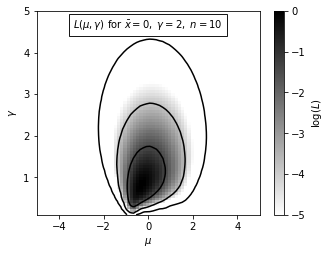

In [ ]:
fig = plt.figure(figsize=(5, 3.75))
plt.imshow(logL, origin='lower', cmap=plt.cm.binary,
           extent=(mu[0], mu[-1], gamma[0], gamma[-1]),
           aspect='auto')
plt.colorbar().set_label(r'$\log(L)$')
plt.clim(-5, 0)

plt.contour(mu, gamma, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='k')

plt.text(0.5, 0.93,
         r'$L(\mu,\gamma)\ \mathrm{for}\ \bar{x}=0,\ \gamma=2,\ n=10$',
         bbox=dict(ec='k', fc='w', alpha=0.9),
         ha='center', va='center', transform=plt.gca().transAxes)

plt.xlabel(r'$\mu$')
plt.ylabel(r'$\gamma$')

plt.show()

## Posterior for Cauchy Distribution
In the prevoius secsion, we use the interquartile range shortcut expressed by $$\sigma_G = 1.483\gamma$$ Here we will use a bootstrap method to estimate parameter uncertainties. 

### 1. define function

In [ ]:
def estimate_mu_gamma(x, axis=None):
    """Equation 3.54: Cauchy point estimates"""
    q25, q50, q75 = np.percentile(x, [25, 50, 75], axis=axis)
    return q50, 0.5 * (q75 - q25)

### 2. Generate sample and use Bootstrap estimation
Draw a random sample from the cauchy distribution, and compute marginalized posteriors of mu and gamma. Here we have a Cauchy distributed sample with N = 10, $\mu = 0$, $\gamma = 2$. 

In [ ]:
np.random.seed(44)

n = 10
mu_0 = 0
gamma_0 = 2
xi = cauchy(mu_0, gamma_0).rvs(n)

gamma = np.linspace(0.01, 5, 70)
dgamma = gamma[1] - gamma[0]

mu = np.linspace(-3, 3, 70)
dmu = mu[1] - mu[0]

likelihood = np.exp(cauchy_logL(xi, gamma[:, np.newaxis], mu))

pmu = likelihood.sum(0)
pmu /= pmu.sum() * dmu

pgamma = likelihood.sum(1)
pgamma /= pgamma.sum() * dgamma

# bootstrap estimate
mu_bins = np.linspace(-3, 3, 21)
gamma_bins = np.linspace(0, 5, 17)

mu_bootstrap, gamma_bootstrap = bootstrap(xi, 20000, estimate_mu_gamma,
                                          kwargs=dict(axis=1), random_state=0)

### 3. Plot results
We will draw a bootstrap estimation (blue dotted lines) of this Cauchy distributed sample along with the posterior pdf (black solid lines). The left two plots show how the result changes with the change of posterior $\mu$, and the right two plots show how the result changes with the posterior $\gamma$.  
The bottom two plots show the cumulative probability distribution.

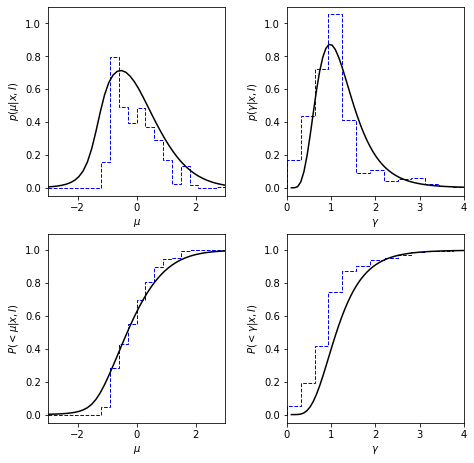

In [ ]:
fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(wspace=0.35, right=0.95,
                    hspace=0.2, top=0.95)

# first axes: mu posterior
ax1 = fig.add_subplot(221)
ax1.plot(mu, pmu, '-k')
ax1.hist(mu_bootstrap, mu_bins, density=True,
         histtype='step', color='b', linestyle='dashed')
ax1.set_xlabel(r'$\mu$')
ax1.set_ylabel(r'$p(\mu|x,I)$')

# second axes: mu cumulative posterior
ax2 = fig.add_subplot(223, sharex=ax1)
ax2.plot(mu, pmu.cumsum() * dmu, '-k')
ax2.hist(mu_bootstrap, mu_bins, density=True, cumulative=True,
         histtype='step', color='b', linestyle='dashed')
ax2.set_xlabel(r'$\mu$')
ax2.set_ylabel(r'$P(<\mu|x,I)$')
ax2.set_xlim(-3, 3)

# third axes: gamma posterior
ax3 = fig.add_subplot(222, sharey=ax1)
ax3.plot(gamma, pgamma, '-k')
ax3.hist(gamma_bootstrap, gamma_bins, density=True,
         histtype='step', color='b', linestyle='dashed')
ax3.set_xlabel(r'$\gamma$')
ax3.set_ylabel(r'$p(\gamma|x,I)$')
ax3.set_ylim(-0.05, 1.1)

# fourth axes: gamma cumulative posterior
ax4 = fig.add_subplot(224, sharex=ax3, sharey=ax2)
ax4.plot(gamma, pgamma.cumsum() * dgamma, '-k')
ax4.hist(gamma_bootstrap, gamma_bins, density=True, cumulative=True,
         histtype='step', color='b', linestyle='dashed')
ax4.set_xlabel(r'$\gamma$')
ax4.set_ylabel(r'$P(<\gamma|x,I)$')
ax4.set_ylim(-0.05, 1.1)
ax4.set_xlim(0, 4)

plt.show()